<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center> Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 6.  Vowpal Wabbit

На этой неделе мы познакомимся с популярной библиотекой Vowpal Wabbit и попробуем ее на данных соревнования. Знакомиться будем на [данных](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) Scikit-learn по новостям, сначала в режиме бинарной классификации, затем – в многоклассовом режиме. Затем будем классифицировать рецензии к фильмам с сайта IMDB. Наконец, применим Vowpal Wabbit к данным нашего соревнования. Материала немало, но Vowpal Wabbit того стоит!

**План 6 недели:**
- Часть 1. Тьюториал по Vowpal Wabbit. Новости. Бинарная классификация
- Часть 2. Тьюториал по Vowpal Wabbit. Новости. Многоклассовая классификация
- Часть 3. Тьюториал по Vowpal Wabbit. Рецензии к фильмам IMDB
- Часть 4. Применение Vowpal Wabbit к данным по посещению сайтов


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
Также будет полезна [презентация](https://github.com/esokolov/ml-course-msu/blob/master/ML15/lecture-notes/Sem08_vw.pdf) лектора специализации Евгения Соколова. И, конечно же, [документация](https://github.com/JohnLangford/vowpal_wabbit/wiki) Vowpal Wabbit. Данный материал стал основой [статьи](https://habrahabr.ru/company/ods/blog/326418/) на Хабре из серии открытого курса по машинному обучению.

## Часть 1. Тьюториал по Vowpal Wabbit. Новости. Бинарная классификация

Vowpal Wabbit (VW) является одной из наиболее широко используемых библиотек в индустрии. Её отличает высокая скорость работы и поддержка большого количества различных режимов обучения. Особый интерес для больших и высокоразмерных данных представляет онлайн-обучение – самая сильная сторона библиотеки. 


Основным интерфейсом для работы с VW является shell.

In [1]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [27]:
#!doskey vw="C:\\Program Files\\VowpalWabbit\\vw.exe"

Для того чтобы изучить возможные режимы работы vw воспользуемся командой ! для запуска:

In [2]:
!"C:\\Program Files\\VowpalWabbit\\vw.exe" --help



VW options:
  --random_seed arg                     seed random number generator
  --ring_size arg                       size of example ring

Update options:
  -l [ --learning_rate ] arg            Set learning rate
  --power_t arg                         t power value
  --decay_learning_rate arg             Set Decay factor for learning_rate 
                                        between passes
  --initial_t arg                       initial t value
  --feature_mask arg                    Use existing regressor to determine 
                                        which parameters may be updated.  If no
                                        initial_regressor given, also used for 
                                        initial weights.

Weight options:
  -i [ --initial_regressor ] arg        Initial regressor(s)
  --initial_weight arg                  Set all weights to an initial value of 
                                        arg.
  --random_weights arg                  mak

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


Vowpal Wabbit считывает данные из файла или стандартного ввода (stdin) в формате, который имеет следующий вид:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]`

`Features=(String[:Value] )*`

где [] обозначает необязательные элементы, а (...)\* означает повтор неопределенное число раз. 

- **Label** является числом, "правильным" ответом. В случае классификации обычно принимает значение 1/-1, а в случае регрессии некоторое вещественное число
- **Importance** является числом и отвечает за вес примера при обучении. Это позволяет бороться с проблемой несбалансированных данных, изученной нами ранее
- **Tag** является некоторой строкой без пробелов и отвечает за некоторое "название" примера, которое сохраняется при предсказании ответа. Для того, чтобы отделить Tag от Importance лучше начинать Tag с символа '.
- **Namespace** служит для создания отдельных пространств признаков. В аргументах Namespace именуются по первой букве, это нужно учитывать при выборе их названий
- **Features** являются непосредственно признаками объекта внутри **Namespace**. Признаки по умолчанию имеют вес 1.0, но его можно переопределить, к примеру feature:0.1. 


К примеру, под такой формат подходит следующая строка:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```


чтобы убедиться в этом, запустим vw с этим обучающим примером:

In [3]:
!@python --version

Python 3.6.0 :: Anaconda 4.3.0 (64-bit)


In [4]:
!echo "1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park" | "C:\\Program Files\\VowpalWabbit\\vw.exe"

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0   0.0000   0.0000       10

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 0.000000
average loss = 0.000000
total feature number = 10


In [5]:
! echo "1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park" | "C:\\Program Files\\VowpalWabbit\\vw.exe" 

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0   0.0000   0.0000       10

finished run
number of examples per pass = 1
passes used = 1
weighted example sum = 1.000000
weighted label sum = 0.000000
average loss = 0.000000
total feature number = 10


VW является прекрасным инструментом для работы с текстовыми данными. Убедимся в этом с помощью выборки 20newsgroups, содержащей новости из 20 различных тематических рассылок:

In [5]:
newsgroups = sklearn.datasets.fetch_20newsgroups('news_data/')

In [6]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Рассмотрим первый текстовый документ этой коллекции:

In [7]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


**Приведем данные к формату Vowpal Wabbit, при этом оставляя только слова не короче 3 символов. Здесь мы не выполняем многие важные в анализе текстов процедуры (стемминг и лемматизацию), но, как увидим, задача и так будет решаться хорошо.**

In [8]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

Разобьем выборку на обучающую и тестовую и запишем в файл преобразованные таким образом документы. Будем считать документ положительным, если он относится к рассылке про автомобили **rec.autos**. Так мы построим модель, отличающую новости про автомобили от остальных: 

In [9]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
               else -1 for target in newsgroups['target']]

In [11]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=17)
    
with open('news_data/20news_train.vw', 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open('news_data/20news_test.vw', 'w', encoding='utf-8')  as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Запустим Vowpal Wabbit на сформированном файле. Мы решаем задачу классификации, поэтому зададим функцию потерь в значение hinge (линейный SVM). Построенную модель мы сохраним в соответствующий файл `20news_model.vw`:

In [12]:
!"C:\\Program Files\\VowpalWabbit\\vw.exe" -d news_data/20news_train.vw --loss_function hinge -f news_data/20news_model.vw

final_regressor = news_data/20news_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = news_data/20news_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      144
0.500000 0.000000            2            2.0  -1.0000  -1.0000      270
0.340324 0.180648            4            4.0  -1.0000  -0.9480      244
0.417071 0.493818            8            8.0  -1.0000  -1.0000      151
0.283219 0.149366           16           16.0  -1.0000  -1.0000      128
0.211971 0.140724           32           32.0  -1.0000  -0.3997       28
0.116923 0.021875           64           64.0  -1.0000  -1.0000      103
0.158355 0.199787          128          128.0  -1.0000  -0.8313      127
0.125210 0.092065          256          256.0  -1.0000  -0.9422       46
0.150460

Модель обучена. VW выводит достаточно много полезной информации по ходу обучения. Обратите внимание, что average loss снижался по ходу выполнения итераций. Для вычисления функции потерь VW использует еще не просмотренные примеры, поэтому, как правило, эта оценка является корректной. Применим обученную модель на тестовой выборке, сохраняя предсказания в файл с помощью опции -p: 

In [13]:
!"C:\\Program Files\\VowpalWabbit\\vw.exe" -i news_data/20news_model.vw -t -d news_data/20news_test.vw \
-p news_data/20news_test_predictions.txt

only testing
predictions = news_data/20news_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = news_data/20news_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown  -1.0000      143
0.000000 0.000000            2            2.0  unknown  -1.0000       42
0.000000 0.000000            4            4.0  unknown  -0.8455       72
0.000000 0.000000            8            8.0  unknown   0.5062       54
0.000000 0.000000           16           16.0  unknown  -1.0000      796
0.000000 0.000000           32           32.0  unknown  -1.0000      187
0.000000 0.000000           64           64.0  unknown  -0.5900      215
0.000000 0.000000          128          128.0  unknown  -1.0000      139
0.000000 0.000000          256          256.0  unknown  -1.00

Загрузим полученные предсказания, вычислим AUC и отобразим ROC-кривую:

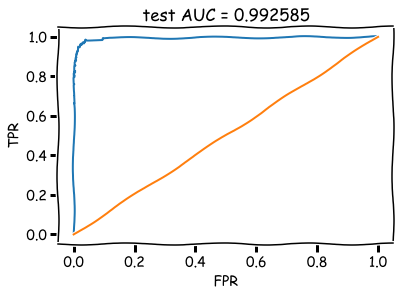

In [14]:
with open('news_data/20news_test_predictions.txt') as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = sklearn.metrics.roc_auc_score(test_labels, test_prediction)
roc_curve = sklearn.metrics.roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

Полученное значения AUC говорит о высоком качестве классификации.

## Часть 2. Тьюториал по Vowpal Wabbit. Новости. Многоклассовая классификация

**Используем ту же выборку, что в прошлой части , но решаем задачу многоклассовой классификации. Тут Vowpal Wabbit слегка капризничает – он любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 20). Поэтому придется применить LabelEncoder, да еще и +1 потом добавить (LabelEncoder переводит метки в диапозон от 0 до K-1).**

In [15]:
all_documents = newsgroups['data']
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups['target']) + 1

**Выборки будут те же, а метки поменяются, `train_labels_mult` и `test_labels_mult` – векторы меток от 1 до 20.**

In [16]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=17)

In [17]:
with open('news_data/20news_train_mult.vw', 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with open('news_data/20news_test_mult.vw', 'w', encoding='utf-8') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

**Обучим Vowpal Wabbit в режиме многоклассовой классификации, передав параметр *oaa* (от "one against all"), равный числу классов. Также перечислим параметры, которые можно понастраивать, и от которых качество модели может довольно значительно зависеть (более полно – в официальном [тьюториале](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial) по Vowpal Wabbit):**
 - темп обучения (-l, по умолчанию 0.5) – коэффициент перед изменением весов модели при каждом изменении
 - степень убывания темпа обучения (--power_t, по умолчанию 0.5) – на практике проверено, что если темп обучения уменьшается при увеличении числа итераций стохастического градиентного спуска, то минимум функции находится лучше 
 - функция потерь (--loss_function) – от нее, по сути, зависит обучаемый алгоритм
 - регуляризация (-l1) – тут надо обратить внимание на то, что в VW регуляризация считается для каждого объекта, поэтому коэффициенты регуляризации обычно берутся малыми, около $10^{-20}.$
 
 **Дополнительно: в соревновании можно попробовать автоматическую настройку параметров Vowpal Wabbit с Hyperopt. Пока это работает только с Python 2. [Статья](https://habrahabr.ru/company/dca/blog/272697/) на Хабре.**

In [18]:
%%time
!"C:\\Program Files\\VowpalWabbit\\vw.exe" --oaa 20 news_data/20news_train_mult.vw -f news_data/20news_model_mult.vw \
--loss_function=hinge

final_regressor = news_data/20news_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = news_data/20news_train_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0        1        1      144
0.500000 1.000000            2            2.0       16        1      270
0.750000 1.000000            4            4.0       10       14      244
0.875000 1.000000            8            8.0       13       10      151
0.937500 1.000000           16           16.0        9       17      128
0.875000 0.812500           32           32.0       15        5       28
0.875000 0.875000           64           64.0        3        3      103
0.835938 0.796875          128          128.0       15       15      127
0.750000 0.664063          256          256.0       20        3       4

Wall time: 1.35 s


In [19]:
%%time
!"C:\\Program Files\\VowpalWabbit\\vw.exe" -i news_data/20news_model_mult.vw -t -d news_data/20news_test_mult.vw \
-p news_data/20news_test_predictions_mult.txt

only testing
predictions = news_data/20news_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = news_data/20news_test_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown        4      143
1.000000 1.000000            2            2.0  unknown        5       42
1.000000 1.000000            4            4.0  unknown       13       72
1.000000 1.000000            8            8.0  unknown        8       54
1.000000 1.000000           16           16.0  unknown        1      796
1.000000 1.000000           32           32.0  unknown       11      187
1.000000 1.000000           64           64.0  unknown       13      215
1.000000 1.000000          128          128.0  unknown       13      139
1.000000 1.000000          256          256.0  unkn

Wall time: 481 ms


In [20]:
with open('news_data/20news_test_predictions_mult.txt') as pred_file:
    test_prediction_mult = [float(label) 
                             for label in pred_file.readlines()]

In [21]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.87133262636974196

**Выведем раскрашенную матрицу ошибок полученного классификатора.**

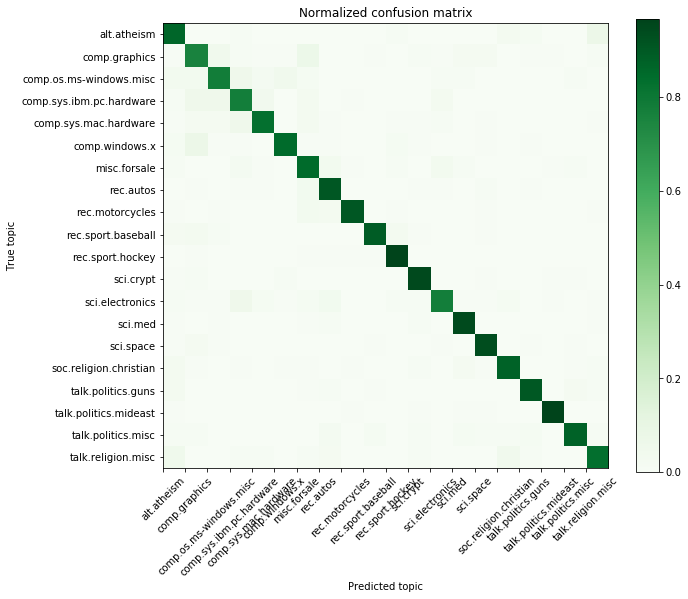

In [22]:
from sklearn.metrics import confusion_matrix

M = confusion_matrix(test_labels_mult, test_prediction_mult)
M_normalized = M.astype('float') / M.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
im = plt.imshow(M_normalized, interpolation='nearest', cmap='Greens')
plt.colorbar(im, shrink=0.71)
tick_marks = np.arange(len(newsgroups['target_names']))
plt.xticks(tick_marks - 0.5, newsgroups['target_names'], rotation=45)
plt.yticks(tick_marks, newsgroups['target_names'])
plt.tight_layout()
plt.ylabel('True topic')
plt.xlabel('Predicted topic')
plt.title('Normalized confusion matrix')
plt.show()

## Часть 3. Тьюториал по Vowpal Wabbit. Рецензии к фильмам IMDB

**В этой части мы будем заниматься бинарной классификацией отзывов к фильмам, публикованным на сайте IMDB. Обратите внимание, насколько быстро будет работать Vowpal Wabbit.**

**Используем функцию `load_files` из `sklearn.datasets` для загрузки отзывов по фильмам [отсюда](https://yadi.sk/d/Tg1Tflur333iLr). Скачайте данные и положите рядом с этой тетрадкой в каталог *imdb_reviews* (в нем должны быть каталоги *train* и *test*). Разархивирование может занять несколько минут – там 100 тыс. файлов. В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам. Отделим данные (собственно тексты) от меток.**

In [23]:
from sklearn.datasets import load_files

In [41]:
# Поменяйте на свой путь
#PATH_TO_MOVIE_DATA = 'C://Users//Evtisov_SS//Documents//GitHub//Coursera-machine-learning//final//project_web//week6//imdb'
PATH_TO_MOVIE_DATA = 'C://temp//aclImdb'
#/Users/y.kashnitsky/Yandex.Disk.localized/ML/data/imdb_reviews'

In [42]:
reviews_train = load_files(os.path.join(PATH_TO_MOVIE_DATA, 'train'))
text_train, y_train = reviews_train.data, reviews_train.target

In [43]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


То же самое с тестовой выборкой.

In [44]:
reviews_test = load_files(os.path.join(PATH_TO_MOVIE_DATA, 'test'))
text_test, y_test = reviews_test.data, reviews_train.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Примеры отзывов и соответствующих меток.**

In [45]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [46]:
y_train[0] # хороший отзыв

1

In [47]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [48]:
y_train[1] # плохой отзыв

0

**Будем использовать ранее написанную функцию `to_vw_format`.**

In [49]:
to_vw_format(str(text_train[1]), 1 if y_train[0] == 1 else -1)

'1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

**Подготовим обучающую (`movie_reviews_train.vw`), отложенную (`movie_reviews_valid.vw`) и тестовую (`movie_reviews_test.vw`) выборки для Vowpal Wabbit. 70% исходной обучаюшей выборки оставим под обучение, 30% – под отложенную выборку.**

In [50]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [51]:
len(train_labels), len(valid_labels)

(17500, 7500)

In [53]:
with open(os.path.join(PATH_TO_MOVIE_DATA, 'movie_reviews_train.vw'), 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train, train_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open(os.path.join(PATH_TO_MOVIE_DATA, 'movie_reviews_valid.vw'), 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(valid, valid_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open(os.path.join(PATH_TO_MOVIE_DATA, 'movie_reviews_test.vw'), 'w', encoding='utf-8') as vw_test_data:
    for text in text_test:
        vw_test_data.write(to_vw_format(str(text)))

In [54]:
!head -2 $PATH_TO_MOVIE_DATA/movie_reviews_train.vw

"head" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [35]:
!head -2 $PATH_TO_MOVIE_DATA/movie_reviews_valid.vw

1 |text matter life and death what can you really say that would properly justice the genius and beauty this film powell and pressburger visual imagination knows bounds every frame filled with fantastically bold compositions the switches between the bold colours the real world the stark black and white heaven ingenious showing visually just how much more vibrant life the final court scene also fantastic the judge and jury descend the stairway heaven hold court over peter david niven operation all the performances are spot roger livesey being standout and the romantic energy the film beautiful never has there been more romantic film than this there has haven seen matter life and death all about the power love and just how important life and jack cardiff cinematography reason enough watch the film alone the way lights kim hunter face makes her all the more beautiful what genius can make simple things such game table tennis look exciting and the sound design also impeccable the way the so

In [36]:
!head -2 $PATH_TO_MOVIE_DATA/movie_reviews_test.vw

 |text don hate heather graham because she beautiful hate her because she fun watch this movie like the hip clothing and funky surroundings the actors this flick work well together casey affleck hysterical and heather graham literally lights the screen the minor characters goran visnjic sigh and patricia velazquez are talented they are gorgeous congratulations miramax director lisa krueger
 |text don know how this movie has received many positive comments one can call artistic and beautifully filmed but those things don make for the empty plot that was filled with sexual innuendos wish had not wasted time watch this movie rather than being biographical was poor excuse for promoting strange and lewd behavior was just another hollywood attempt convince that that kind life normal and from the very beginning asked self what was the point this movie and continued watching hoping that would change and was quite disappointed that continued the same vein glad did not spend the money see this t

**Обучим модель Vowpal Wabbit со следующими агрументами:**

 - -d, путь к обучающей выборке (соотв. файл .vw )
 - --loss_function – hinge (хотя можно и поэкспериментировать с другими)
 - -f – путь к файлу, в который запишется модель (можно тоже в формате .vw)

In [55]:
!"C:\\Program Files\\VowpalWabbit\\vw.exe" -d $PATH_TO_MOVIE_DATA/movie_reviews_train.vw \
--loss_function hinge -f $PATH_TO_MOVIE_DATA/movie_reviews_model.vw

final_regressor = C://temp//aclImdb/movie_reviews_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = C://temp//aclImdb/movie_reviews_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000      105
1.324514 1.649029            2            2.0  -1.0000   0.6490      164
1.274999 1.225483            4            4.0  -1.0000   0.2310      110
1.071162 0.867325            8            8.0  -1.0000   0.4609      219
1.063382 1.055602           16           16.0   1.0000  -0.5401      204
0.987534 0.911686           32           32.0   1.0000   0.2172      190
1.016583 1.045631           64           64.0  -1.0000   0.3521      126
0.917219 0.817854          128          128.0  -1.0000  -1.0000      106
0.863816 0.810413          256          256.0  -1.0

**Сделаем прогноз для отложенной выборки с помощью обученной модели Vowpal Wabbit, передав следующие аргументы:**
 - -i –путь к обученной модели (соотв. файл .vw)
 - -t -d – путь к отложенной выборке (соотв. файл .vw)
 - -p – путь к txt-файлу, куда запишутся прогнозы

In [56]:
!"C:\\Program Files\\VowpalWabbit\\vw.exe" -i $PATH_TO_MOVIE_DATA/movie_reviews_model.vw \
-t -d $PATH_TO_MOVIE_DATA/movie_reviews_valid.vw \
-p $PATH_TO_MOVIE_DATA/movie_valid_pred.txt

only testing
predictions = C://temp//aclImdb/movie_valid_pred.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = C://temp//aclImdb/movie_reviews_valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0   1.0000   1.0000      204
0.016776 0.033551            2            2.0   1.0000   0.8168      132
0.008388 0.000000            4            4.0   1.0000   1.0000       97
0.012055 0.015722            8            8.0   1.0000   1.0000      128
0.301133 0.590210           16           16.0   1.0000   0.9068       35
0.287625 0.274117           32           32.0   1.0000   1.0000      268
0.488315 0.689006           64           64.0   1.0000   0.7265       92
0.408818 0.329320          128          128.0   1.0000   1.0000      272
0.396541 0.384265          256          256.

**Считаем прогноз из файла и посчитаем долю правильных ответов и ROC AUC. Учтем, что VW выводит оценки вероятности принадлежности к классу +1. Эти оценки распределены на [-1, 1], поэтому бинарным ответом алгоритма (0 или 1) будем попросту считать тот факт, что оценка получилась положительной.**

In [58]:
with open(os.path.join(PATH_TO_MOVIE_DATA, 'movie_valid_pred.txt')) as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.885
AUC: 0.942


**Сделаем то же самое для тестовой выборки.**

In [60]:
!"C:\\Program Files\\VowpalWabbit\\vw.exe" -i $PATH_TO_MOVIE_DATA/movie_reviews_model.vw \
-t -d $PATH_TO_MOVIE_DATA/movie_reviews_test.vw \
-p $PATH_TO_MOVIE_DATA/movie_test_pred.txt

only testing
predictions = C://temp//aclImdb/movie_test_pred.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = C://temp//aclImdb/movie_reviews_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown   0.1245       59
0.000000 0.000000            2            2.0  unknown  -1.0000      103
0.000000 0.000000            4            4.0  unknown  -1.0000      161
0.000000 0.000000            8            8.0  unknown  -0.8256      365
0.000000 0.000000           16           16.0  unknown   1.0000      319
0.000000 0.000000           32           32.0  unknown   1.0000       95
0.000000 0.000000           64           64.0  unknown  -0.9379      139
0.000000 0.000000          128          128.0  unknown  -0.7748       92
0.000000 0.000000          256          256.0 

In [61]:
with open(os.path.join(PATH_TO_MOVIE_DATA, 'movie_test_pred.txt')) as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Accuracy: 0.88
AUC: 0.94


**Попробуем улучшить прогноз за счет задействования биграмм.**

In [62]:
!"C:\\Program Files\\VowpalWabbit\\vw.exe" -d $PATH_TO_MOVIE_DATA/movie_reviews_train.vw \
--loss_function hinge --ngram 2 -f $PATH_TO_MOVIE_DATA/movie_reviews_model2.vw

Generating 2-grams for all namespaces.
final_regressor = C://temp//aclImdb/movie_reviews_model2.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = C://temp//aclImdb/movie_reviews_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000      208
1.163564 1.327128            2            2.0  -1.0000   0.3271      326
1.132272 1.100979            4            4.0  -1.0000   0.1421      218
1.038996 0.945721            8            8.0  -1.0000  -0.0209      436
1.066398 1.093799           16           16.0   1.0000  -0.3067      406
1.015723 0.965048           32           32.0   1.0000   0.1252      378
0.998668 0.981614           64           64.0  -1.0000   0.1228      250
0.944884 0.891100          128          128.0  -1.0000  -0.5893      210
0.915717 0.

In [63]:
!"C:\\Program Files\\VowpalWabbit\\vw.exe" -i $PATH_TO_MOVIE_DATA/movie_reviews_model2.vw \
-t -d $PATH_TO_MOVIE_DATA/movie_reviews_valid.vw \
-p $PATH_TO_MOVIE_DATA/movie_valid_pred2.txt

Generating 2-grams for all namespaces.
only testing
predictions = C://temp//aclImdb/movie_valid_pred2.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = C://temp//aclImdb/movie_reviews_valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0   1.0000   1.0000      406
0.058499 0.116998            2            2.0   1.0000   0.6580      262
0.029249 0.000000            4            4.0   1.0000   1.0000      192
0.039642 0.050034            8            8.0   1.0000   1.0000      254
0.260827 0.482012           16           16.0   1.0000   0.5979       68
0.277697 0.294567           32           32.0   1.0000   1.0000      534
0.381055 0.484414           64           64.0   1.0000   0.6431      182
0.304856 0.228656          128          128.0   1.0000   0.8595      542
0.35

In [64]:
with open(os.path.join(PATH_TO_MOVIE_DATA, 'movie_valid_pred2.txt')) as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.894
AUC: 0.954


In [66]:
!"C:\\Program Files\\VowpalWabbit\\vw.exe" -i $PATH_TO_MOVIE_DATA/movie_reviews_model2.vw \
-t -d $PATH_TO_MOVIE_DATA/movie_reviews_test.vw \
-p $PATH_TO_MOVIE_DATA/movie_test_pred2.txt

Generating 2-grams for all namespaces.
only testing
predictions = C://temp//aclImdb/movie_test_pred2.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = C://temp//aclImdb/movie_reviews_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown  -0.0426      116
0.000000 0.000000            2            2.0  unknown  -1.0000      204
0.000000 0.000000            4            4.0  unknown  -1.0000      320
0.000000 0.000000            8            8.0  unknown  -1.0000      728
0.000000 0.000000           16           16.0  unknown   1.0000      636
0.000000 0.000000           32           32.0  unknown   0.9573      188
0.000000 0.000000           64           64.0  unknown  -0.4484      276
0.000000 0.000000          128          128.0  unknown  -0.8634      182
0.0000

In [67]:
with open(os.path.join(PATH_TO_MOVIE_DATA, 'movie_test_pred2.txt')) as pred_file:
    test_prediction2 = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))

Accuracy: 0.888
AUC: 0.952


Видим, что биграммы помогли повысить качество классификации.

## Часть 4. Применение Vowpal Wabbit к данным по посещению сайтов

**Загрузим созданные ранее pickle-объекты, соответствующие разреженным данным [соревнования](https://inclass.kaggle.com/c/identify-me-if-you-can4/data), которые мы создали на прошлой неделе.**

In [47]:
import pickle

In [48]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '/Users/y.kashnitsky/Documents/Machine_learning/ML_yandex_mipt_spec_repo/' + \
               'dev/final_project/capstone_websites_data2' 

In [49]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'rb') as X_train_sparse_pkl:
    X_train_sparse = pickle.load(X_train_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'rb') as X_test_sparse_pkl:
    X_test_sparse = pickle.load(X_test_sparse_pkl)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'rb') as train_target_pkl:
    y = pickle.load(train_target_pkl)

In [50]:
X_train_sparse.shape, X_test_sparse.shape

((182793, 36656), (46473, 36656))

**Vowpal Wabbit любит, чтоб метки классов были распределены от 1 до K, где K – число классов в задаче классификации (в нашем случае – 550). Поэтому придется применить LabelEncoder, да еще и +1 потом добавить (LabelEncoder переводит метки в диапозон от 0 до K-1).**

In [51]:
class_encoder = LabelEncoder().fit(y)

In [52]:
y_for_vw = class_encoder.transform(y) + 1

**Выделим обучающую и оставленную части исходной обучающей выборки.**

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y_for_vw, test_size=0.3, 
                                                     random_state=17, stratify=y_for_vw)

**Реализуйте функцию, переводящую разреженную матрицу в формат Vowpal Wabbit.**

Вход:
 - X_sparse – разреженная матрица SciPy.sparse.csr_matrix
 - y (необяз.) - вектор ответов. Необязателен, поскольку тестовую матрицу будем обрабатывать этой же функцией
 - out_file – путь к файлу .vw, в который будет произведена запись
 
Детали:
- можно делать по-разному, но скорее всего поможет метод *nonzero* разреженной матрицы
- в тестовой выборке на месте меток целевого класса можно писать произвольные, допустим, 1

In [54]:
def sparse_matrix_to_vw(X_sparse, y=None, out_file='tmp.vw'):
    ''' ВАШ КОД ЗДЕСЬ '''

**Примените написанную функцию к части обучащей выборки (X_train, y_train), к отложенной выборке (X_valid, y_valid), ко всей обучающей выборке (X_train_sparse, y_for_vw) и ко всей тестовой выборке X_test_sparse.**

In [55]:
%%time
sparse_matrix_to_vw(X_train, y_train, os.path.join(PATH_TO_DATA, 'train_part.vw'))
sparse_matrix_to_vw(X_valid, y_valid, os.path.join(PATH_TO_DATA, 'valid.vw'))
sparse_matrix_to_vw(X_train_sparse, y_for_vw, os.path.join(PATH_TO_DATA, 'train.vw'))
sparse_matrix_to_vw(X_test_sparse, out_file=os.path.join(PATH_TO_DATA, 'test.vw'))

100%|██████████| 46473/46473 [00:31<00:00, 1461.78it/s]

CPU times: user 3min 10s, sys: 5.99 s, total: 3min 16s
Wall time: 3min 13s


In [56]:
!head -3 $PATH_TO_DATA/train_part.vw

85 | sites 295:4 296:6
76 | sites 10:1 89:1 79:1 126:1 11:1 87:1 52:1 111:1 88:2
96 | sites 3000:1 2888:3 3961:6


In [57]:
!head -3  $PATH_TO_DATA/valid.vw

347 | sites 1608:1 1231:1 1114:2 49:1
189 | sites 7874:1 18532:1 18531:4 18533:4
175 | sites 1199:1 17135:9


In [58]:
!head -3 $PATH_TO_DATA/train.vw

262 | sites 23713:8 23720:2
82 | sites 5320:3 45:2 8725:2 665:1 8727:1 8726:1
16 | sites 303:8 309:1 19:1


In [59]:
!head -3 $PATH_TO_DATA/test.vw

1 | sites 308:2 300:1 91:1 9:1 312:1 309:1 307:1 305:1 304:1
1 | sites 838:3 11:2 504:1 886:1 68:1 27:1 305:1
1 | sites 190:2 189:2 8:2 192:2 191:1 2375:1


**Обучите модель на выборке `train_part.vw`. Укажите, что решается задача классификации с 400 классами (*--oaa*), сделайте 3 прохода по выборке (*--passes*). Задайте некоторый кэш-файл (*--cache_file*, можно просто указать флаг -c), так VW будет быстрее делать все следующие после первого проходы по выборке (прошлый кэш-файл удаляется с помощью аргумента *-k*). Также укажите значение параметра b=26. Это число бит, используемых для хэширования, в данном случае нужно больше, чем 18 по умолчанию. Наконец, укажите *random_seed=17*. Остальные параметры пока не меняйте, далее уже в свободном режиме соревнования можете попробовать другие функции потерь.**

In [ ]:
train_part_vw = os.path.join(PATH_TO_DATA, 'train_part.vw')
valid_vw = os.path.join(PATH_TO_DATA, 'valid.vw')
train_vw = os.path.join(PATH_TO_DATA, 'train.vw')
test_vw = os.path.join(PATH_TO_DATA, 'test.vw')
model = os.path.join(PATH_TO_DATA, 'vw_model.vw')
pred = os.path.join(PATH_TO_DATA, 'vw_pred.csv')

In [ ]:
%%time
!vw --oaa 400 ''' ВАШ КОД ЗДЕСЬ '''

**Запишите прогнозы на выборке *valid.vw* в *vw_valid_pred.csv*.**

In [ ]:
%%time
!vw -t ''' ВАШ КОД ЗДЕСЬ '''

**Считайте прогнозы *kaggle_data/vw_valid_pred.csv*  из файла и посмотрите на долю правильных ответов на отложенной части.**

In [ ]:
vw_valid_pred = pd.read_csv ''' ВАШ КОД ЗДЕСЬ '''
accuracy_score ''' ВАШ КОД ЗДЕСЬ '''

**Какой получается доля правильных ответов на отложенной выборке? Запишите в файл *answer6_1.txt*, округлив до 3 знаков после запятой.**

In [ ]:
def write_answer_to_file(answer, file_address):
    with open(file_address, 'w') as out_f:
        out_f.write(str(answer))

In [ ]:
write_answer_to_file(''' ВАШ КОД ЗДЕСЬ '''
                     'answer6_1.txt')

**Обучите модель с теми же параметрами на всей обучающей выборке – *train.vw*.**

In [ ]:
%%time
!vw --oaa 400 ''' ВАШ КОД ЗДЕСЬ '''

**Сделайте прогноз для тестовой выборки.**

In [ ]:
%%time
!vw -t ''' ВАШ КОД ЗДЕСЬ '''

**Запишите прогноз в файл, примените обратное преобразование меток (был LabelEncoder и потом +1 в меткам) и отправьте решение на Kaggle.**

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
vw_pred = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
vw_subm = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
write_to_submission_file(vw_subm, pred)

## Напутствие

Итак, мы познакомились с отличной библиотекой Vowpal Wabbit. Хотя это только начало: в VW реализованы матричные разложения и обучение с подкреплением, тематическое моделирование и активное обучение, name entity recognition и нейронные сети. Если Вам придется как-нибудь обучать модель на терабайте данных, при этом расходуя несколько мегабайт оперативной памяти, Вы наверняка вернетесь к этому тьюториалу (если, конечно, не выпустят библиотеку с более удобным интерфейсом). Хочется верить, что именно эта часть проекта оказалось самой полезной!

## Пути улучшения
На этой неделе, как видите, заданий под моим руководством мало – намного больше именно тьюториалов по Vowpal Wabbit. Зато, как и на прошлой неделе, дается время на соревнование и офрмление финального проекта.
Что еще можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели
 - Настройть параметры Vowpal Wabbit с hyperopt
 - Попробовать TF-IDF и n-граммы

На следующей, заключительной, неделе мы оформим всю работу над проектом в виде одного файла (`html`, `pdf` или `ipynb`) и будем проверять проекты друг друга.